In [419]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import glob

from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split
from lightgbm import LGBMRegressor
from scipy import stats

In [4]:
path = '/home/mrmopoz/git/data/kaggle/optiver-realized-volatility-prediction'

In [5]:
# paths to book train files
list_order_book_file_train = sorted(glob.glob(path +'/book_train.parquet/*'))
# path to closed trade
list_trade_file_train = sorted(glob.glob(path + '/trade_train.parquet/*'))
# target
train_target = pd.read_csv(path + '/train.csv')
train_target['row_id'] = train_target['stock_id'].astype(str) + '-' + train_target['time_id'].astype(str)

In [6]:
train_target.head()

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62


In [8]:
display(list_order_book_file_train[0])
display(list_trade_file_train[0])

order_book_0 = pd.read_parquet(list_order_book_file_train[0])
trade_0 = pd.read_parquet(list_trade_file_train[0])

'/home/mrmopoz/git/data/kaggle/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0'

'/home/mrmopoz/git/data/kaggle/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0'

In [9]:
order_book_0.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


In [10]:
order_book_0[order_book_0['time_id']==5]

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3


In [96]:
order_book_0(order_book_0['bid_size1'] % 10 == 0).astype(int)

0         False
1         False
2         False
3         False
4         False
          ...  
917548     True
917549    False
917550    False
917551    False
917552    False
Name: bid_size1, Length: 917553, dtype: bool

<AxesSubplot:>

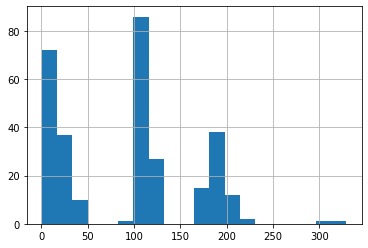

In [295]:
order_book_0[order_book_0['time_id']==5]['ask_size2'].hist(bins=20)

<AxesSubplot:>

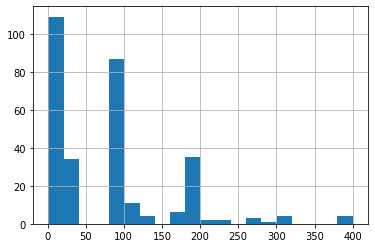

In [294]:
order_book_0[order_book_0['time_id']==5]['bid_size2'].hist(bins=20)

<AxesSubplot:>

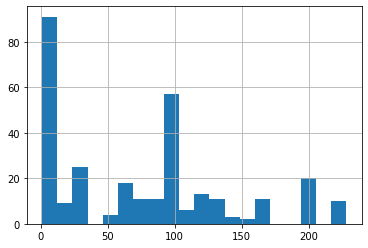

In [292]:
order_book_0[order_book_0['time_id']==5]['ask_size1'].hist(bins=20)

<AxesSubplot:>

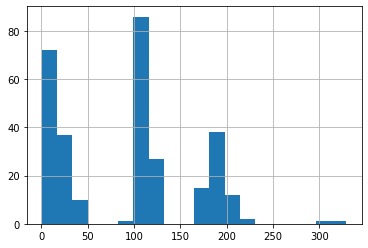

In [293]:
order_book_0[order_book_0['time_id']==5]['ask_size2'].hist(bins=20)

## Rolling metrics

In [24]:
def rolling_volatility_per_time_id(file):
    #read data_from file
    df_book_data = pd.read_parquet(file)
    
    # calculate weighted price
    df_book_data['wap_1'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+\
                          df_book_data['ask_price1'] * df_book_data['bid_size1']) /\
                        (df_book_data['bid_size1']+ df_book_data['ask_size1'])
    
    # calculate log return for each time id
    df_book_data['log_return_1'] = df_book_data.groupby(['time_id'])['wap_1'].apply(log_return)
    
    #calculate rolling volatility
    realized_vol_per_stock =  df_book_data.groupby(['time_id'], as_index=False)\
                                          .rolling(window=100).agg({'log_return_1':realized_volatility})
    return realized_vol_per_stock, df_book_data

In [25]:
realized_vol_per_stock, df_book_data = rolling_volatility_per_time_id(list_order_book_file_train[0])

<AxesSubplot:>

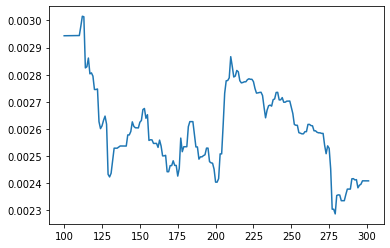

In [27]:
realized_vol_per_stock.reset_index().query('time_id==5')['log_return_1'].plot()

<AxesSubplot:>

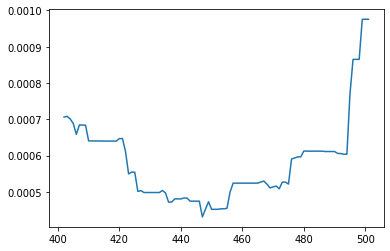

In [26]:
realized_vol_per_stock.reset_index().query('time_id==11')['log_return_1'].plot()

<AxesSubplot:>

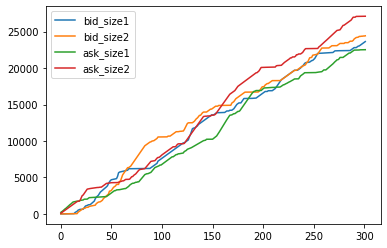

In [36]:
df_book_data.query('time_id==5')[['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2' ]].cumsum().plot()

In [44]:
pd.merge(trade_0[trade_0['time_id']==5], 
         df_book_data.query('time_id==5')[['seconds_in_bucket' ,
                                           'bid_size1', 'bid_size2', 
                                           'ask_size1', 'ask_size2' ]],
        on='seconds_in_bucket')

,time_id,seconds_in_bucket,price,size,order_count,bid_size1,bid_size2,ask_size1,ask_size2
0,5,21,1.002301,326,12,3,2,30,100
1,5,46,1.002778,128,4,155,200,1,34
2,5,50,1.002818,55,1,3,100,20,301
3,5,57,1.003155,121,5,200,28,104,200
4,5,68,1.003646,4,1,100,11,100,34
5,5,78,1.003762,134,5,19,28,9,20
6,5,122,1.004207,102,3,30,200,101,3
7,5,127,1.004577,1,1,30,200,100,3
8,5,144,1.004370,6,1,32,200,100,5
9,5,147,1.003964,233,4,200,2,100,1


In [71]:
trade_0['log_ret'] = trade_0.groupby('time_id')['price'].apply(log_return).diff()#plot()

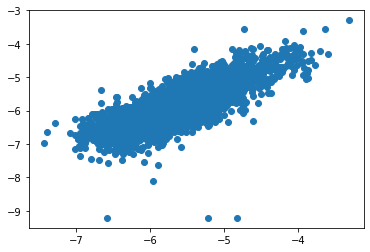

In [158]:
temp = pd.merge(train_target.query('stock_id == 0'), 
                trade_0.groupby('time_id')\
                        .agg({'log_ret':realized_volatility})\
                        .rename(columns={'log_ret':'real_vol'})\
                        .reset_index(),
                on='time_id')

plt.scatter(np.log(temp['target']), np.log(temp['real_vol']+ 10e-5))

In [79]:
rolling_trade_vol = trade_0.groupby('time_id')\
                           .rolling(20)\
                           .agg({'log_ret':realized_volatility})

<AxesSubplot:xlabel='time_id,None'>

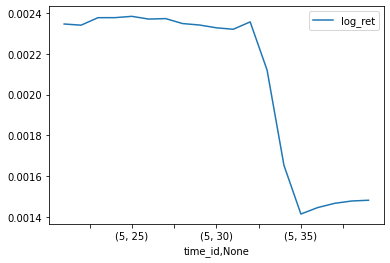

In [82]:
rolling_trade_vol.query('time_id==5').plot()

<AxesSubplot:>

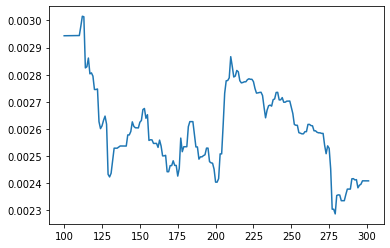

In [81]:
realized_vol_per_stock.reset_index().query('time_id==5')['log_return_1'].plot()

## Book metrics

In [434]:
df = agg_book_features(list_order_book_file_train[0])

In [218]:
df.head()

,time_id,real_volatrealized_volatility,real_volat_2realized_volatility,bid_price1min,bid_price1max,bid_price1mean,bid_price1std,bid_price2min,bid_price2max,bid_price2mean,...,ask_price1mean,ask_price1std,ask_price2min,ask_price2max,ask_price2mean,ask_price2std,real_volat_log,real_volat_2_log,stock_id,row_id
0,5,0.004499,0.006999,1.001422,1.004267,1.003320,0.000587,1.001370,1.004215,1.003144,...,1.004175,0.000592,1.002353,1.005146,1.004326,0.000594,-5.403818,-4.962056,0,0-5
1,11,0.001204,0.002476,0.999473,1.000627,1.000014,0.000282,0.999423,1.000477,0.999872,...,1.000407,0.000219,1.000176,1.001179,1.000541,0.000217,-6.721776,-6.000964,0,0-11
2,16,0.002369,0.004801,0.997008,1.000120,0.999202,0.000712,0.996721,0.999928,0.999006,...,0.999926,0.000789,0.997966,1.000981,1.000124,0.000786,-6.045453,-5.338926,0,0-16
3,31,0.002574,0.003637,0.997363,0.999815,0.998434,0.000680,0.997178,0.999769,0.998243,...,0.999295,0.000560,0.998566,1.000601,0.999404,0.000561,-5.962399,-5.616603,0,0-31
4,62,0.001894,0.003257,0.999044,0.999790,0.999406,0.000218,0.998858,0.999650,0.999216,...,0.999802,0.000190,0.999557,1.000303,0.999911,0.000195,-6.268874,-5.727002,0,0-62


## Trade metrics

In [347]:
trade_df = agg_trade_features(list_trade_file_train[0])

In [282]:
trade_df.head()

,row_id,pricemin,pricemax,pricestd,sizesum,sizemax,sizemean,sizestd,order_countmax,order_countmean,order_countstd,trade_volume,trade_std
0,0-1000,0.997787,0.999803,0.000554,900,153,30.000000,45.806941,10,2.133333,2.029665,0.016622,0.000018
1,0-10000,0.999465,1.000778,0.000373,1940,612,80.833333,132.567839,13,2.916667,2.500725,0.030131,0.000005
2,0-10005,0.997692,1.003423,0.001756,2363,407,81.482759,119.468950,14,3.137931,3.502286,0.143074,0.000022
3,0-10017,0.990542,1.005349,0.004358,3769,500,89.738095,134.024399,19,3.166667,3.875606,0.391100,0.000049
4,0-10030,0.998655,1.000045,0.000493,2943,320,98.100000,103.272438,8,2.333333,1.667816,0.048367,0.000005


In [437]:
trade_0.head()

,time_id,seconds_in_bucket,price,size,order_count,log_ret,row_id
0,5,21,1.002301,326,12,NaN,0-5
1,5,46,1.002778,128,4,NaN,0-5
2,5,50,1.002818,55,1,-0.000435,0-5
3,5,57,1.003155,121,5,0.000296,0-5
4,5,68,1.003646,4,1,0.000153,0-5


## Entropia

In [311]:
df_book_data = pd.read_parquet(list_order_book_file_train[0])
    # calculate weighted price
df_book_data['wap_1'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+\
                            df_book_data['ask_price1'] * df_book_data['bid_size1']) /\
                           (df_book_data['bid_size1']+ df_book_data['ask_size1'])
    

In [312]:
df_book_data['log_return_1'] = df_book_data.groupby(['time_id'])['wap_1'].apply(log_return)
df_book_data = df_book_data.dropna().reset_index(drop=True)

## MSG coding

In [ ]:
def binary_coding(value):
    if value > 0: return 1
    if value < 0: return 0
    if value == 0: return np.nan
    
df_book_data['return_bincode'] = df_book_data['log_return_1'].apply(binary_coding)

## First case

In [398]:
def plugIn(msg, w):
    pmf = pmf1(msg, w)
    out = -sum([pmf[i] * np.log2(pmf[i]) for i in pmf]) / w
    return out
def pmf1(msg, w):
    lib={}
    if not isinstance(msg, str): 
        msg = msg.dropna()
        msg=''.join(map(str, msg))
    for i in range(w, len(msg)):
        msg_ = msg[i-w:i]
        if msg_ not in lib:
            lib[msg_] = [i-w]
        else:
            lib[msg_] = lib[msg_] + [i-w]
    pmf = float(len(msg)-w)
    pmf = {i:len(lib[i])/pmf for i in lib}
    return pmf
    

In [ ]:
%%time
plig_ent = df_book_data.groupby('time_id')['return_bincode'].apply(lambda series: plugIn(series, w=10))
plig_ent = plig_ent.to_frame().rename(columns={'return_bincode':'entropy'})
plig_ent['boxcox_ent'] = stats.boxcox(plig_ent['entropy'])[0]

## Second case

In [357]:
def matchLength(msg, i, n):
    subS = ''
    for l in range(n):
        msg1 = msg[i:i+l+1]
        for j in range(i-n, i):
            msg0 = msg[j:j+l+1]
            if msg1 ==msg0:
                subS = msg1
                break
    return len(subS) + 1, subS

def konto(msg, window=None):
    out = {'num':0, 'sum':0, 'subS':[]}
    if not isinstance(msg, str): 
        msg = msg.dropna()
        msg=''.join(map(str, msg))
    if window is None:
        points = range(1, len(msg)//2+1)
        #ENCODING SCHEMES 269
    else:
        window = min(window, len(msg)//2)
        points = range(window, len(msg)-window+1)
        
    for i in points:
        if window is None:
            l, msg_ = matchLength(msg, i, i)
            out['sum'] += np.log2(i+1)/l
        else: 
            l, msg_ = matchLength(msg, i, window)
            out['sum'] += np.log2(window+1)/l
        out['subS'].append(msg_)
        out['num'] += 1
    out['h'] = out['sum'] / out['num']
    out['r'] = 1 - out['h']/np.log2(len(msg))
    return out

In [359]:
%%time
entrop_dicts = df_book_data.groupby('time_id')['return_bincode'].apply(konto)

CPU times: user 1h 4min 50s, sys: 25.4 s, total: 1h 5min 15s
Wall time: 1h 5min 16s


In [364]:
res = entrop_dicts.reset_index()
res = res[res['level_1'].isin(('h', 'r'))]
res = res.pivot(index='time_id', columns='level_1', values='return_bincode')
res = res.reset_index()
res['h'] = pd.to_numeric(res['h'])
res['r'] = pd.to_numeric(res['r'])
res['volat'] = np.exp(res['h'] - 1/2)  / (2*np.pi)**0.5

In [402]:
%%time
msg_len = df_book_data.groupby('time_id')['return_bincode'].apply(lambda ser: len(ser.dropna()))

CPU times: user 428 ms, sys: 3.94 ms, total: 432 ms
Wall time: 430 ms


In [435]:
temp = pd.merge(df, train_target[['row_id', 'target']], on='row_id')
temp = pd.merge(temp, trade_df, on='row_id')
temp = pd.merge(temp, plig_ent, on='time_id')
temp['target_log'] = np.log(temp['target'])

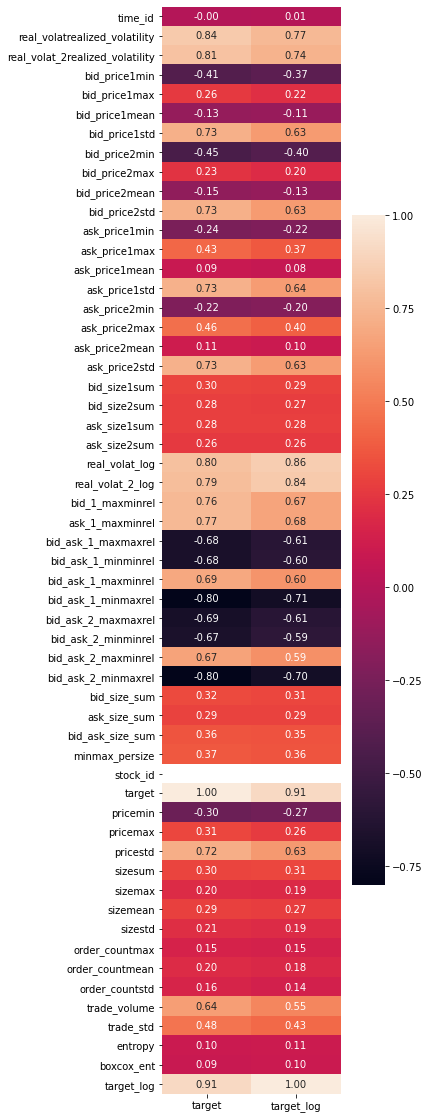

In [436]:
plt.figure(figsize=(4,20))
sns.heatmap(temp.drop(columns='row_id').corr()[['target', 'target_log']], annot=True, fmt='.2f');

# Modeling

## Add features
1. Differences and realations between  max and min ask/bid prcies
2. Statisitcs of price (min/max/mean/std bid/ask/trad)
3. Rolling statictics (last few)
    3.1. Detect change point and use data only on right from change point
4. Entropy
5. Corwin Shultz
6. Lambdas
7. Parts of orders
8. Forecast price on the next window 

In [457]:
RANDOM_STATE = 42

def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def rmspe_lgbm(y_true, y_pred):
    eval_name ='rmspe'
    eval_result = rmspe(y_true, y_pred)
    is_higher_better = False
    return  (eval_name, eval_result, is_higher_better) 


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def process_data(paths, process):
    df_data = pd.DataFrame()
    for file in paths:
        df =  process(file)
        df_data = pd.concat([df_data, df])
        
    return df_data
    

def agg_book_features(file):
    #read data_from file
    df_book_data = pd.read_parquet(file)
    # calculate weighted price
    df_book_data['wap_1'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+\
                            df_book_data['ask_price1'] * df_book_data['bid_size1']) /\
                           (df_book_data['bid_size1']+ df_book_data['ask_size1'])
    
    df_book_data['wap_2'] =(df_book_data['bid_price2'] * df_book_data['ask_size2']+\
                            df_book_data['ask_price2'] * df_book_data['bid_size2']) /\
                           (df_book_data['bid_size2']+ df_book_data['ask_size2'])
    
    # calculate log return for each time id
    df_book_data['log_return_1'] = df_book_data.groupby(['time_id'])['wap_1'].apply(log_return)
    df_book_data['log_return_2'] = df_book_data.groupby(['time_id'])['wap_2'].apply(log_return)
    # drop nan values
    df_book_data = df_book_data.dropna()#[~df_book_data['log_return'].isnull()]
    
    # calculate volatility
    agg_feature_df =  df_book_data.groupby(['time_id'], as_index=False)\
                                          .agg({'log_return_1':realized_volatility, 
                                                'log_return_2':realized_volatility,
                                                'bid_price1':['min', 'max', 'mean', 'std'],
                                                'bid_price2':['min', 'max', 'mean', 'std'],
                                                'ask_price1':['min', 'max', 'mean', 'std'],
                                                'ask_price2':['min', 'max', 'mean', 'std'],
                                                'bid_size1':['sum'],
                                                'bid_size2':['sum'],
                                                'ask_size1':['sum'],
                                                'ask_size2':['sum'],})
    
    agg_feature_df = agg_feature_df.rename(columns = {'log_return_1':'real_volat', 
                                                                      'log_return_2':'real_volat_2'})
    
    # logarithm of volatility
    agg_feature_df['real_volat_log'] = np.log(agg_feature_df['real_volat'])
    agg_feature_df['real_volat_2_log'] = np.log(agg_feature_df['real_volat_2'])
    
    # unstack columns name
    agg_feature_df.columns = [''.join(map(str, col)) for col in agg_feature_df.columns]
    
    agg_feature_df['bid_1_maxminrel'] = agg_feature_df['bid_price1max'] / agg_feature_df['bid_price1min']
    agg_feature_df['ask_1_maxminrel'] = agg_feature_df['ask_price1max'] / agg_feature_df['ask_price1min']
    agg_feature_df['bid_ask_1_maxmaxrel'] = agg_feature_df['bid_price1max'] / agg_feature_df['ask_price1max']
    agg_feature_df['bid_ask_1_minminrel'] = agg_feature_df['bid_price1min'] / agg_feature_df['ask_price1min']
    agg_feature_df['bid_ask_1_maxminrel'] = agg_feature_df['bid_price1max'] / agg_feature_df['ask_price1min']
    agg_feature_df['bid_ask_1_minmaxrel'] = agg_feature_df['bid_price1min'] / agg_feature_df['ask_price1max']
        
#     agg_feature_df['bid_ask_2_maxmaxrel'] = agg_feature_df['bid_price2max'] / agg_feature_df['ask_price2max']
#     agg_feature_df['bid_ask_2_minminrel'] = agg_feature_df['bid_price2min'] / agg_feature_df['ask_price2min']
#     agg_feature_df['bid_ask_2_maxminrel'] = agg_feature_df['bid_price2max'] / agg_feature_df['ask_price2min']
#     agg_feature_df['bid_ask_2_minmaxrel'] = agg_feature_df['bid_price2min'] / agg_feature_df['ask_price2max']
    
    agg_feature_df['bid_size_sum'] = agg_feature_df['bid_size1sum'] + agg_feature_df['bid_size2sum']
    agg_feature_df['ask_size_sum'] = agg_feature_df['ask_size1sum'] + agg_feature_df['ask_size2sum']
    agg_feature_df['bid_ask_size_sum'] = agg_feature_df['bid_size_sum'] + agg_feature_df['ask_size_sum']
    agg_feature_df['minmax_persize'] =  agg_feature_df['bid_ask_size_sum'] / agg_feature_df['bid_ask_1_minmaxrel']
    
    
    agg_feature_df['size_volat_corr'] = np.corrcoef(agg_feature_df['real_volatrealized_volatility'], 
                                     agg_feature_df['bid_ask_size_sum'])[0][1]
    
    #extract stock_id
    stock_id = file.split('=')[1]
    agg_feature_df['stock_id'] = int(stock_id)
    agg_feature_df['row_id'] = agg_feature_df['time_id'].apply(lambda x:f'{stock_id}-{x}')
    # result df columns: time_id, real_volat, real_volat_2, stock_id, row_id
    return agg_feature_df

def agg_trade_features(file):
    #read data_from file
    df_trade_data = pd.read_parquet(file)
    #extract stock_id
    stock_id = file.split('=')[1]
    df_trade_data['row_id'] = df_trade_data['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    agg_feature_df = df_trade_data.groupby('row_id', as_index=False)\
                                  .agg({'price':['min', 'max', 'std'],
                                        'size': ['sum', 'max', 'mean', 'std'],
                                        'order_count':['max', 'mean', 'std']})
 
    # unstack columns name
    agg_feature_df.columns = [''.join(map(str, col)) for col in agg_feature_df.columns]
    
    agg_feature_df['trade_volume'] = agg_feature_df['pricestd'] * agg_feature_df['sizemean']
    agg_feature_df['trade_std'] = agg_feature_df['pricestd'] / agg_feature_df['sizemean']

    return agg_feature_df


def create_gr_feats(data, cat_feats, num_feats):
    """
    create aggregation feats for numeric features based on categorical ones and count its
    :param num_feats:
    :param cat_feats:
    :param data:
    :return:
    """
    # create aggregation feats for numeric features based on categorical ones
    for cat_col in cat_feats:
        for num_col in num_feats:
            for n, f in [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax)]:
                data['FIXED_' + n + '_' + num_col + '_by_' + cat_col] = \
                    data.groupby(cat_col)[num_col].transform(f)
    return data

def create_predictors(book_path, trade_path):
    #df columns: time_id, real_volat, stock_id, row_id
    df1 = process_data(book_path, agg_book_features)
    df2 = process_data(trade_path, agg_trade_features)
    df = pd.merge(df1, df2, on='row_id')
    # add feature columns
    df = create_gr_feats(df, ['time_id', 'stock_id'], ['real_volat_log', 'real_volat_2_log'])
    return df
    
def predict_volatility(book_path, trade_path, model):
    
    # create predictors
    X_test = create_predictors(book_path, trade_path)
    # predict targets
    y_test = np.exp(model.predict(X_test.drop(columns=['row_id'])))
    
    result = pd.DataFrame()
    result['row_id'] = X_test['row_id']
    result['target'] = y_test
    return result


def train_model(X, target, model):
    X = pd.merge(target[['row_id','target']], X, on = ['row_id'], how = 'left')
     
    y = np.log(X['target'])
    X = X.drop(columns=['row_id', 'target'])
    print(X.shape)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)
    
    #model.fit(X_train, y_train)
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric=rmspe_lgbm,  verbose=100, early_stopping_rounds=20)
 
    return model

def predict(X, model):
    
    result = pd.DataFrame()
    result['row_id'] = X['row_id']
    result['predict'] = np.exp(model.predict(X.drop(columns=['row_id'])))
    return result

## Model

In [592]:
%%time
X = create_predictors(list_order_book_file_train, list_trade_file_train)

CPU times: user 7min 31s, sys: 12.4 s, total: 7min 43s
Wall time: 8min 6s


In [593]:
model = LGBMRegressor(
        learning_rate= 0.03,
        subsample=0.6,
        feature_fraction=0.6,
        num_iterations = 1600,
        max_bin=350,
        num_leaves= 300,
        lambda_l2=0.003,
        max_depth=200,
        min_data_in_leaf= 80,
        force_row_wise= True,
        metric='custom')

model = train_model(X, train_target, model)

(428932, 60)


/home/mrmopoz/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
[100]	training's rmspe: 0.0402763	valid_1's rmspe: 0.0413685
[200]	training's rmspe: 0.0358212	valid_1's rmspe: 0.0378373
[300]	training's rmspe: 0.0334677	valid_1's rmspe: 0.036414
[400]	training's rmspe: 0.0319781	valid_1's rmspe: 0.035813
[500]	training's rmspe: 0.0308744	valid_1's rmspe: 0.0355591
[600]	training's rmspe: 0.0299024	valid_1's rmspe: 0.0354263
[700]	training's rmspe: 0.0289947	valid_1's rmspe: 0.0353142
[800]	training's rmspe: 0.0281542	valid_1's rmspe: 0.0351908
[900]	training's rmspe: 0.0273549	valid_1's rmspe: 0.0350938
[1000]	training's rmspe: 0.0266363	valid_1's rmspe: 0.0350387
[1100]	training's rmspe: 0.0259427	valid_1's rmspe: 0.0350037
Early stopping, best iteration is:
[1166]	training's rmspe: 0.0255135	valid_1's rmspe: 0.0349702


In [588]:
X.shape

(428913, 85)

In [599]:
pd.DataFrame(model.feature_importances_, index=X.drop(columns=['row_id']).columns).sort_values(0, ascending=False)

,0
time_id,17047
FIXED_min_real_volat_log_by_time_id,16283
FIXED_max_real_volat_log_by_time_id,16029
FIXED_max_real_volat_2_log_by_time_id,15814
FIXED_min_real_volat_2_log_by_time_id,15708
FIXED_mean_real_volat_log_by_time_id,14231
FIXED_mean_real_volat_2_log_by_time_id,13670
sizesum,8059
order_countmean,7961
bid_ask_1_maxmaxrel,7550


## Metrics

In [600]:
%%time
res = predict(X, model)
errors = pd.merge(train_target[['target', 'row_id']], res, on='row_id')

CPU times: user 1min 58s, sys: 231 ms, total: 1min 58s
Wall time: 11.5 s


In [602]:
rmspe(errors['target'], errors['predict'])

0.17679519123931028

In [478]:
r2_score(errors['target'], errors['predict'])

0.9200388742484176

In [601]:
r2_score(errors['target'], errors['predict'])

0.9134480145162069

## All dataset 

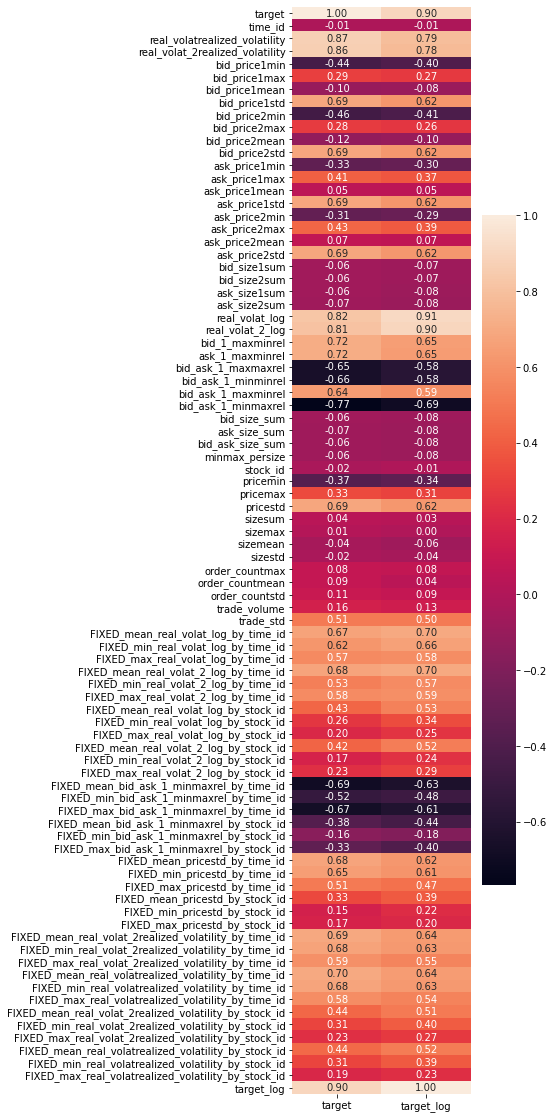

In [474]:
X_ = create_gr_feats(X, ['time_id', 'stock_id'], ['real_volat_2_log', 'real_volat_log', 
                                                  'bid_ask_1_minmaxrel', 'pricestd'])
temp = pd.merge(train_target[['row_id','target']], X_, on = ['row_id'], how = 'left')
temp['target_log'] = np.log(temp['target'])
plt.figure(figsize=(4,20))
sns.heatmap(temp.drop(columns='row_id').corr()[['target', 'target_log']], annot=True, fmt='.2f');

In [576]:
temp.columns

Index(['row_id', 'target', 'time_id', 'real_volatrealized_volatility',
       'real_volat_2realized_volatility', 'bid_price1min', 'bid_price1max',
       'bid_price1mean', 'bid_price1std', 'bid_price2min', 'bid_price2max',
       'bid_price2mean', 'bid_price2std', 'ask_price1min', 'ask_price1max',
       'ask_price1mean', 'ask_price1std', 'ask_price2min', 'ask_price2max',
       'ask_price2mean', 'ask_price2std', 'bid_size1sum', 'bid_size2sum',
       'ask_size1sum', 'ask_size2sum', 'real_volat_log', 'real_volat_2_log',
       'bid_1_maxminrel', 'ask_1_maxminrel', 'bid_ask_1_maxmaxrel',
       'bid_ask_1_minminrel', 'bid_ask_1_maxminrel', 'bid_ask_1_minmaxrel',
       'bid_size_sum', 'ask_size_sum', 'bid_ask_size_sum', 'minmax_persize',
       'stock_id', 'pricemin', 'pricemax', 'pricestd', 'sizesum', 'sizemax',
       'sizemean', 'sizestd', 'order_countmax', 'order_countmean',
       'order_countstd', 'trade_volume', 'trade_std',
       'FIXED_mean_real_volat_log_by_time_id',
       '

In [589]:
np.corrcoef(temp.query('stock_id == 31')['real_volatrealized_volatility'], 
        temp.query('stock_id == 31')['bid_ask_1_maxmaxrel'])[0][1]

-0.17557508881221656

In [590]:
np.corrcoef(temp.query('stock_id == 15')['real_volatrealized_volatility'], 
        temp.query('stock_id == 15')['bid_ask_1_maxmaxrel'])[0][1]

-0.7911023860576157

In [591]:
np.corrcoef(temp.query('stock_id == 37')['real_volatrealized_volatility'], 
        temp.query('stock_id == 37')['bid_ask_1_maxmaxrel'])[0][1]

-0.7581975015234165

## Errors exploration

In [603]:
errors = pd.merge(train_target[['target', 'row_id']], res, on='row_id')
errors.head()

,target,row_id,predict
0,0.004136,0-5,0.004285
1,0.001445,0-11,0.001635
2,0.002168,0-16,0.002563
3,0.002195,0-31,0.002339
4,0.001747,0-62,0.002064


In [604]:
errors['error'] = errors['target'] - errors['predict']
errors['rel_sq_error'] = np.square(errors['error'] / errors['target'])

errors['stock'] = errors['row_id'].str.split('-').str.get(0)
errors['time'] = errors['row_id'].str.split('-').str.get(1)

<AxesSubplot:>

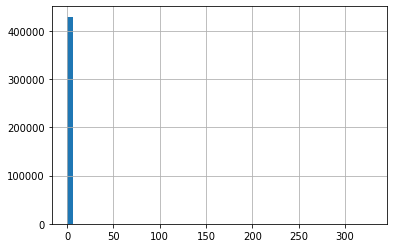

In [605]:
errors['rel_sq_error'].hist(bins=50)

In [521]:
errors['rel_sq_error'].describe()

count    4.289130e+05
mean     2.792566e-02
std      4.412798e-01
min      4.643034e-14
25%      1.957017e-03
50%      8.934674e-03
75%      2.786663e-02
max      2.700692e+02
Name: rel_sq_error, dtype: float64

In [536]:
errors['rel_sq_error'].mean()**0.5

0.16710973286584266

In [606]:
up_error = []
for trash in np.arange(0.1, 3.1, 0.1):
    up_error.append(errors['rel_sq_error'].apply(lambda val: val if val < trash else trash).mean()**0.5)

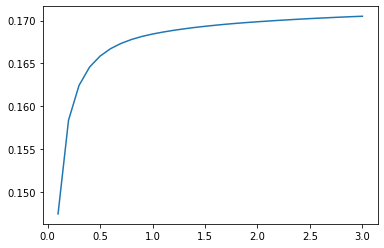

In [607]:
plt.plot(np.arange(0.1, 3.1, 0.1), up_error)

In [608]:
errors[errors['rel_sq_error'] > 0.5]['stock'].value_counts(normalize=True).head(20)

31     0.088255
37     0.033944
18     0.032587
33     0.031908
58     0.029871
60     0.025798
30     0.025119
88     0.025119
80     0.024440
110    0.023082
27     0.022403
112    0.020367
16     0.019688
7      0.019009
81     0.017651
40     0.017651
103    0.017651
98     0.016972
38     0.016293
3      0.015614
Name: stock, dtype: float64

In [609]:
errors[errors['rel_sq_error'] > 0.5]['stock'].value_counts(normalize=True).tail(20)

15     0.002037
96     0.002037
20     0.002037
120    0.002037
104    0.001358
93     0.001358
76     0.001358
59     0.001358
61     0.001358
2      0.001358
119    0.001358
56     0.001358
124    0.000679
14     0.000679
73     0.000679
34     0.000679
84     0.000679
50     0.000679
35     0.000679
69     0.000679
Name: stock, dtype: float64

In [610]:
errors[errors['rel_sq_error'] > 3]

,target,row_id,predict,error,rel_sq_error,stock,time
24215,0.001500,6-10480,0.004369,-0.002868,3.655207,6,10480
57640,0.000354,16-1587,0.001302,-0.000948,7.175967,16,1587
80215,0.000401,21-30805,0.001323,-0.000922,5.291743,21,30805
94020,0.001794,27-17398,0.004915,-0.003122,3.029690,27,17398
94400,0.000697,27-20551,0.003333,-0.002635,14.283924,27,20551
...,...,...,...,...,...,...,...
302031,0.000976,88-28020,0.003227,-0.002252,5.325744,88,28020
372038,0.001247,110-4714,0.003742,-0.002495,4.000891,110,4714
372148,0.000980,110-5658,0.002967,-0.001987,4.112872,110,5658
388981,0.001003,114-18147,0.002773,-0.001770,3.116305,114,18147


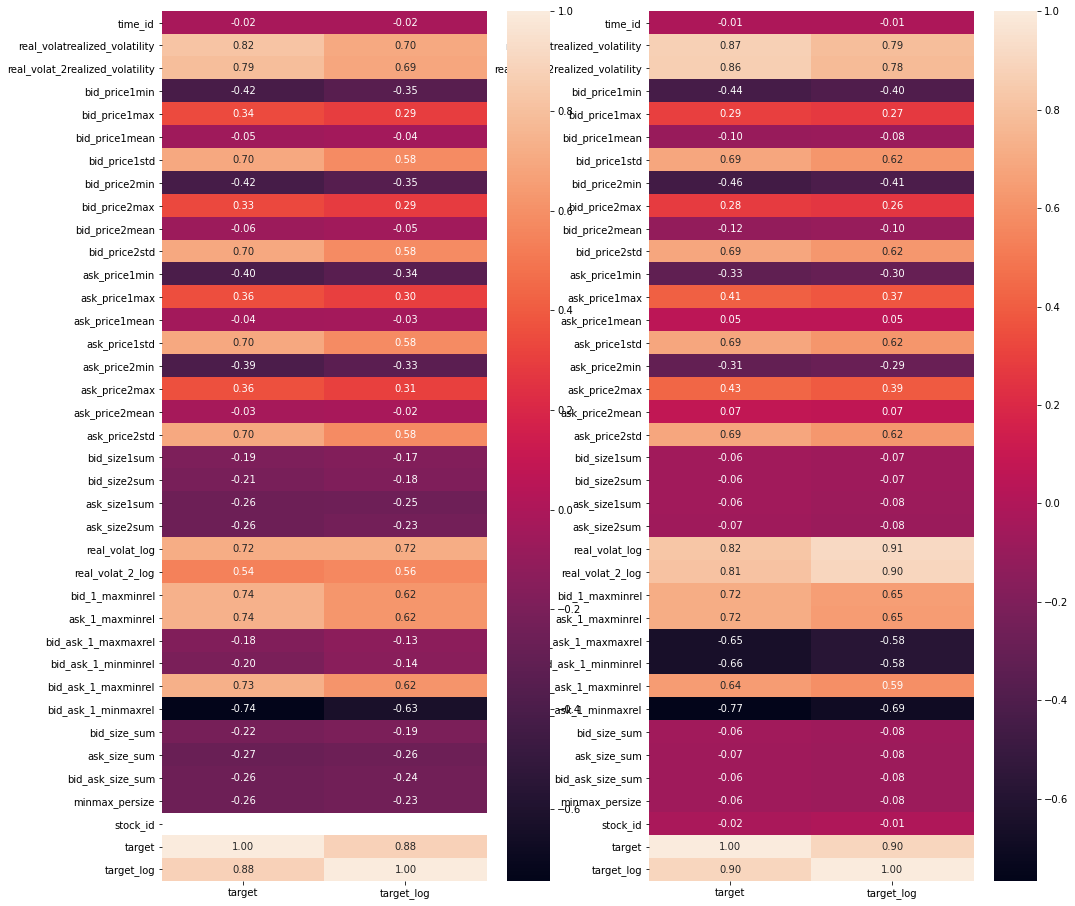

In [611]:
num=31
file = f'/home/mrmopoz/git/data/kaggle/optiver-realized-volatility-prediction/book_train.parquet/stock_id={num}'
df = agg_book_features(file)
temp_1 = pd.merge(df, train_target[train_target['stock_id']==num][['row_id', 'target']])
temp_1['target_log'] = np.log(temp_1['target'])

fig, axs = plt.subplots(1, 2, figsize=(16,16))
sns.heatmap(temp_1.drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[0]);
sns.heatmap(temp[temp_1.columns].drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[1]);

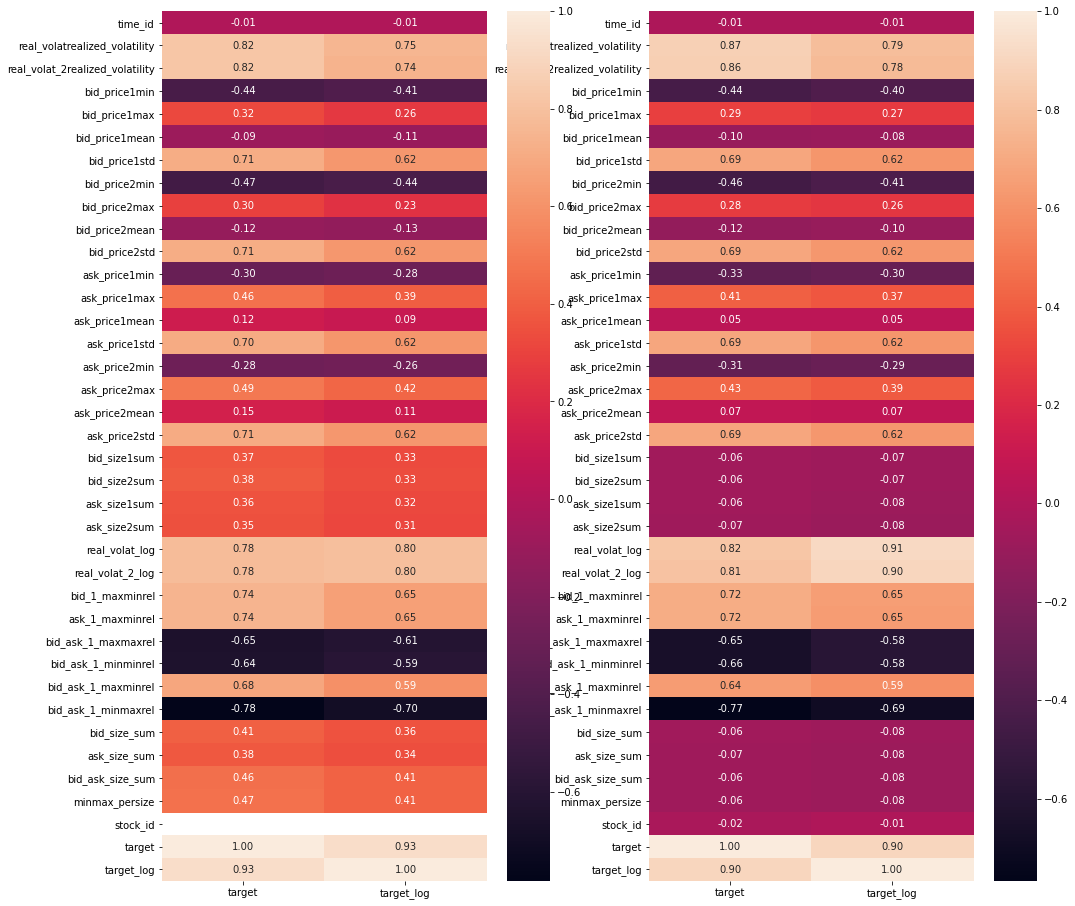

In [566]:
num=37
file = f'/home/mrmopoz/git/data/kaggle/optiver-realized-volatility-prediction/book_train.parquet/stock_id={num}'
df = agg_book_features(file)
temp_1 = pd.merge(df, train_target[train_target['stock_id']==num][['row_id', 'target']])
temp_1['target_log'] = np.log(temp_1['target'])

fig, axs = plt.subplots(1, 2, figsize=(16,16))
sns.heatmap(temp_1.drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[0]);
sns.heatmap(temp[temp_1.columns].drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[1]);

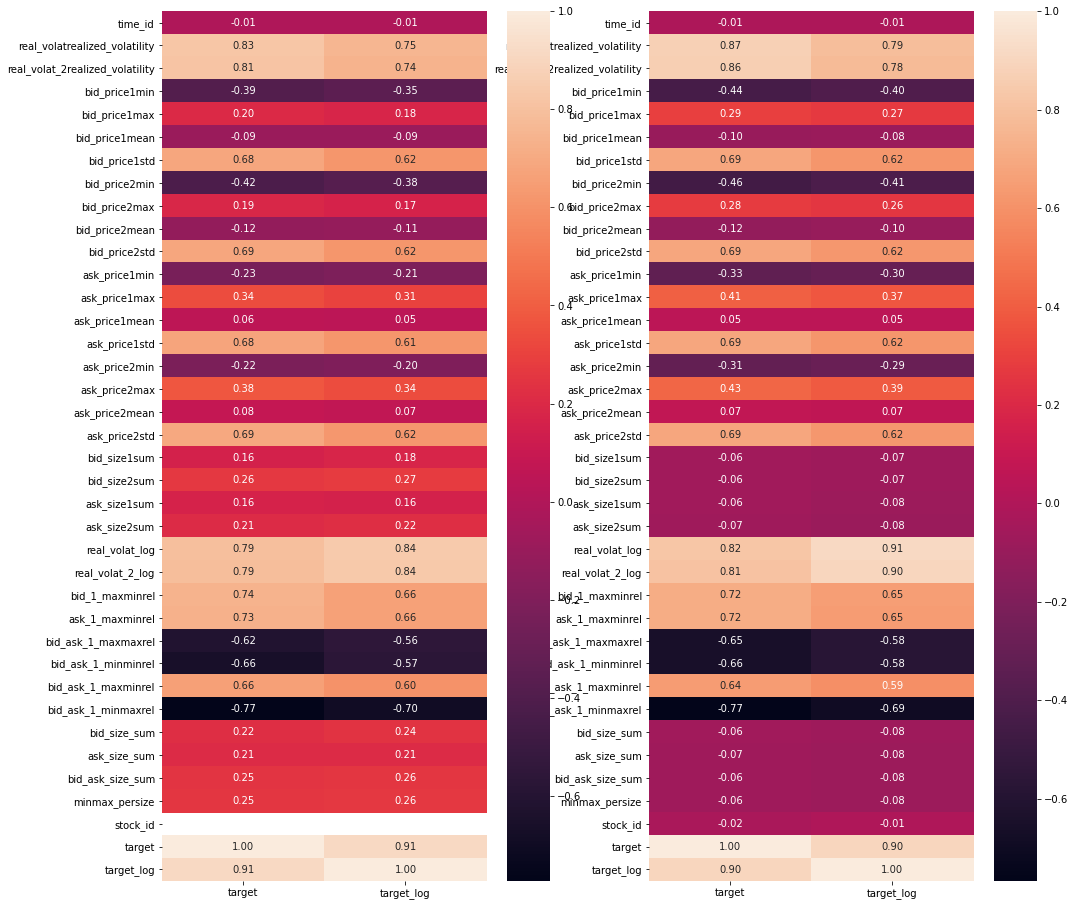

In [567]:
num=60
file = f'/home/mrmopoz/git/data/kaggle/optiver-realized-volatility-prediction/book_train.parquet/stock_id={num}'
df = agg_book_features(file)
temp_1 = pd.merge(df, train_target[train_target['stock_id']==num][['row_id', 'target']])
temp_1['target_log'] = np.log(temp_1['target'])

fig, axs = plt.subplots(1, 2, figsize=(16,16))
sns.heatmap(temp_1.drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[0]);
sns.heatmap(temp[temp_1.columns].drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[1]);

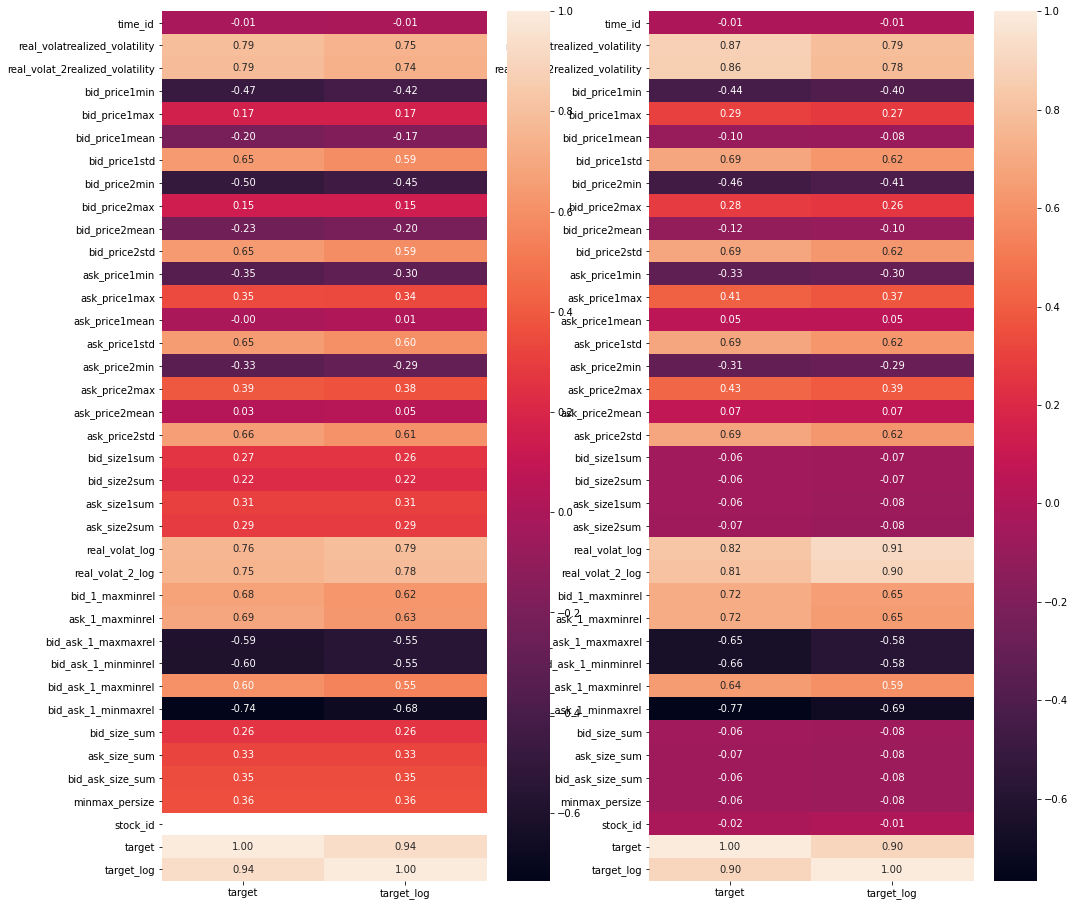

In [568]:
num=18
file = f'/home/mrmopoz/git/data/kaggle/optiver-realized-volatility-prediction/book_train.parquet/stock_id={num}'
df = agg_book_features(file)
temp_1 = pd.merge(df, train_target[train_target['stock_id']==num][['row_id', 'target']])
temp_1['target_log'] = np.log(temp_1['target'])

fig, axs = plt.subplots(1, 2, figsize=(16,16))
sns.heatmap(temp_1.drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[0]);
sns.heatmap(temp[temp_1.columns].drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[1]);

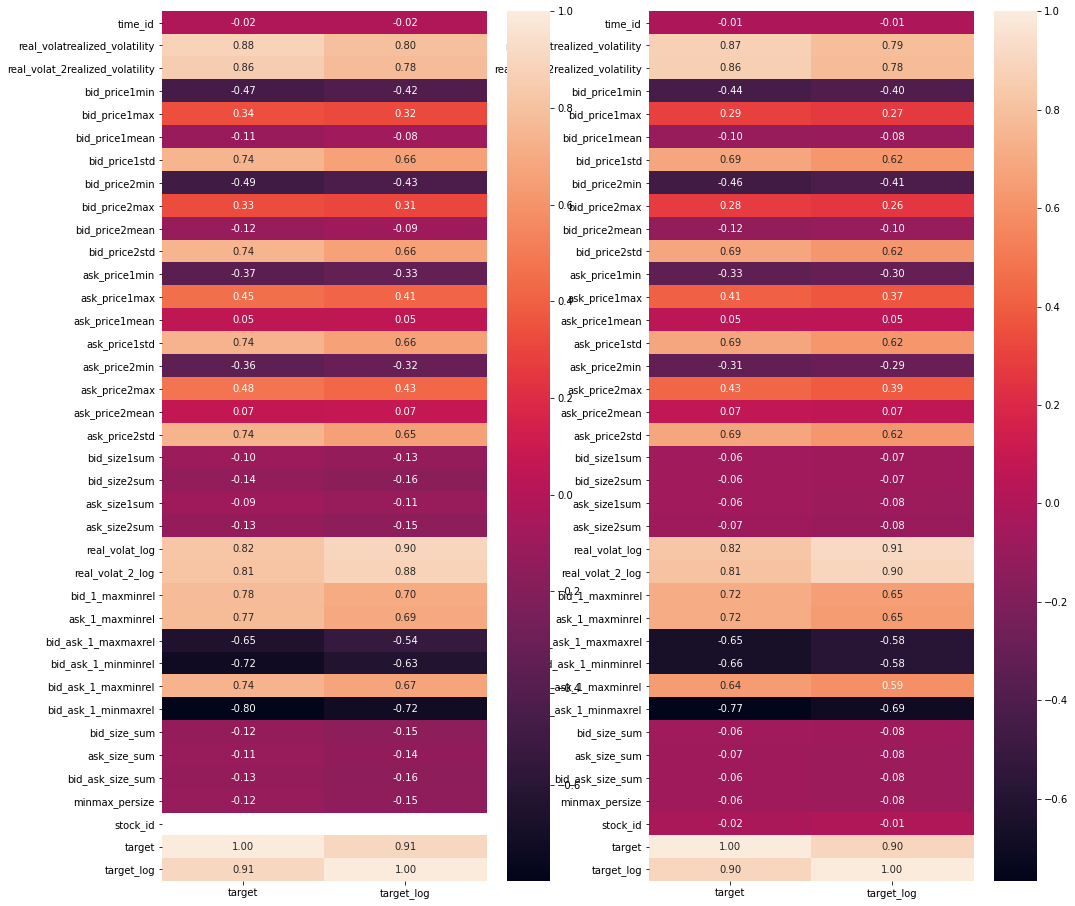

In [572]:
num=15
file = f'/home/mrmopoz/git/data/kaggle/optiver-realized-volatility-prediction/book_train.parquet/stock_id={num}'
df = agg_book_features(file)
temp_1 = pd.merge(df, train_target[train_target['stock_id']==num][['row_id', 'target']])
temp_1['target_log'] = np.log(temp_1['target'])

fig, axs = plt.subplots(1, 2, figsize=(16,16))
sns.heatmap(temp_1.drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[0]);
sns.heatmap(temp[temp_1.columns].drop(columns='row_id').corr()[['target', 'target_log']], 
            annot=True, fmt='.2f', ax=axs[1]);